# Summary
- We used transaction tables for both drug and grocery stores on salty snacks, coffee, and sugar substitude
- We used the product and IRI Week Translation Table
- We aggregate all the three tables above and created new features for season and month from week
- We aggregate the final table at year, season, month level and created the following new features and Targets:
   - Feature: # of Promotions
   - Feature: Display Size Sum 
   - Feature: Ad importance
   - Target: The most popular item within each product category
- We created the following models (can be used for yearly, seasonal, and monthly data):
   - Classifying the most popular item eithin each category
   - Forcasting the sale of each product
   - Predicting the number of units sold for each category
- We evaluated our models by holding out 2011 dataset as our test set.
- We used stacking to improve the performance of our models.
- We did some initial work to underetsand if we can do prescriptive analysis on the given data set (as future work)

# Importing required packages

In [31]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier, BaggingClassifier
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import scale
from sklearn import datasets
import pandas as pd
from sklearn import preprocessing, cross_validation
from pandas.tools.plotting import scatter_matrix
from sklearn import grid_search
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor, DecisionTreeClassifier, ExtraTreeClassifier
from itertools import combinations
from sklearn import decomposition
from sklearn.metrics import mean_squared_error
from collections import Counter
from datetime import date, datetime

%pylab inline
pd.set_option('display.max_columns', 500)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


# Data Collection
we used local data aggregation for this final model as we didn't have time to migrate the table to the postgreq server on AWS. However for all previous models we did most of the data cleaning and merge/join operations on the database on AWS and imported the 'prepared' tables directly to python. 

In [32]:
# as the transaction tables are too big, we sample some of them
dr_sampling_rate=0.3
gr_sampling_rate=0.05

In [4]:
# getting the drug store salty snack products for 2008-2011 and aggregate them
saltsnck_dr_8=pd.read_fwf('saltsnck_drug_1479_1530').sample(frac=dr_sampling_rate)
saltsnck_dr_9=pd.read_fwf('saltsnck_drug_1531_1582').sample(frac=dr_sampling_rate)
saltsnck_dr_10=pd.read_fwf('saltsnck_drug_1583_1634').sample(frac=dr_sampling_rate)
saltsnck_dr_11=pd.read_fwf('saltsnck_drug_1635_1686').sample(frac=dr_sampling_rate)
saltsnck_dr_8_11=pd.concat([saltsnck_dr_8,saltsnck_dr_9,saltsnck_dr_10,saltsnck_dr_11]).reset_index(drop=True)
saltsnck_dr_8_11['OUTLET']='dr'

In [2]:
# getting the drug store sugar substitude products for 2008-2011 and aggregate them
sugarsub_dr_8=pd.read_fwf('sugarsub_drug_1479_1530')
sugarsub_dr_9=pd.read_fwf('sugarsub_drug_1531_1582')
sugarsub_dr_10=pd.read_fwf('sugarsub_drug_1583_1634')
sugarsub_dr_11=pd.read_fwf('sugarsub_drug_1635_1686')
sugarsub_dr_8_11=pd.concat([sugarsub_dr_8,sugarsub_dr_9,sugarsub_dr_10,sugarsub_dr_11]).reset_index(drop=True)
sugarsub_dr_8_11['OUTLET']='dr'

In [122]:
# getting the drug store coffee products for 2008-2011 and aggregate them
coffee_dr_8=pd.read_fwf('coffee_drug_1479_1530')
coffee_dr_9=pd.read_fwf('coffee_drug_1531_1582')
coffee_dr_10=pd.read_fwf('coffee_drug_1583_1634')
coffee_dr_11=pd.read_fwf('coffee_drug_1635_1686')
coffee_dr_8_11=pd.concat([coffee_dr_8,coffee_dr_9,coffee_dr_10,coffee_dr_11]).reset_index(drop=True)
coffee_dr_8_11['OUTLET']='dr'

In [5]:
# getting the grocery store salty snack products for 2008-2011 and aggregate them
saltsnck_gr_8=pd.read_fwf('saltsnck_groc_1479_1530').sample(frac=gr_sampling_rate)
saltsnck_gr_9=pd.read_fwf('saltsnck_groc_1531_1582').sample(frac=gr_sampling_rate)
saltsnck_gr_10=pd.read_fwf('saltsnck_groc_1583_1634').sample(frac=gr_sampling_rate)
saltsnck_gr_11=pd.read_fwf('saltsnck_groc_1635_1686').sample(frac=gr_sampling_rate)
saltsnck_gr_8_11=pd.concat([saltsnck_gr_8,saltsnck_gr_9,saltsnck_gr_10,saltsnck_gr_11]).reset_index(drop=True)
saltsnck_gr_8_11['OUTLET']='gr'

In [123]:
# getting the product table for salty snack, sugar substitude, and coffee
saltsnck_prod = pd.read_excel('prod11_saltsnck.xlsx')[['SY','GE','VEND','ITEM','L1','L2']]
sugarsub_prod = pd.read_excel('prod11_sugarsub.xlsx')[['SY','GE','VEND','ITEM','L1','L2']]
coffee_prod = pd.read_excel('prod11_coffee.xlsx')[['SY','GE','VEND','ITEM','L1','L2']]

In [152]:
# creating a list of names of dataframes (to be used later in data_agg function)
trans_list = [saltsnck_dr_8_11,sugarsub_dr_8_11, coffee_dr_8_11]
prod_list = [saltsnck_prod,sugarsub_prod, coffee_prod]

In [153]:
# convert the IRI WEEK_Translation_2008_2011.xls to season, year, and month (some sort of early feature engineering)
from datetime import date, datetime
week_season_translation=pd.read_excel('IRI week translation_2008_2017.xls')
week_season_translation = week_season_translation[\
    ['IRI Week', u'Calendar week starting on',u'Calendar week ending on']]
# if the date falls between March 21 and June 20, it is spring. Regardless of the year. 
Y = 2000 # dummy leap year to allow input X-02-29 (leap day)
seasons = [('winter', (date(Y,  1,  1),  date(Y,  3, 20))),
           ('spring', (date(Y,  3, 21),  date(Y,  6, 20))),
           ('summer', (date(Y,  6, 21),  date(Y,  9, 22))),
           ('fall', (date(Y,  9, 23),  date(Y, 12, 20))),
           ('winter', (date(Y, 12, 21),  date(Y, 12, 31)))]
    
def get_season(rawDate):
    aDate = rawDate
    if isinstance(aDate, datetime):
        aDate = aDate.date()
    aDate = aDate.replace(year=Y)
    
    return next(season for season, (start, end) in seasons
                if start <= aDate <= end)

week_season_translation['season'] = week_season_translation['Calendar week starting on']
week_season_translation['season'] = week_season_translation['season'].apply(get_season)
week_season_translation.rename(columns={'IRI Week':'WEEK'}, inplace=True)
week_season_translation['YEAR']=week_season_translation['Calendar week starting on'].apply(lambda x:x.year)
week_season_translation['MONTH']=week_season_translation['Calendar week starting on'].apply(lambda x:x.month)
week_season_translation.drop(['Calendar week starting on','Calendar week ending on'], axis=1, inplace=True)

In [154]:
# function to aggregate the transaction, product, and year/season/month 
def data_agg(trans_list, prod_list,week_season_translation):
    agg_trans=pd.concat(trans_list)
    agg_prod=pd.concat(prod_list)
    agg_df = pd.merge(agg_trans, agg_prod, on=['SY', 'GE','VEND','ITEM']).drop(['SY', 'GE','VEND','ITEM'],axis=1)
    final_df = pd.merge(agg_df,week_season_translation,on='WEEK')
    return final_df

In [155]:
data_df=data_agg(trans_list, prod_list,week_season_translation)
data_df.head()

,IRI_KEY,WEEK,UNITS,DOLLARS,F,D,PR,OUTLET,L1,L2,season,YEAR,MONTH
0,8002426,1530,1,1.29,NONE,0,0,dr,CATEGORY - SALTY SNACKS,POTATO CHIPS,winter,2008,12
1,8016830,1530,1,1.29,NONE,1,1,dr,CATEGORY - SALTY SNACKS,POTATO CHIPS,winter,2008,12
2,931511,1530,3,3.87,NONE,2,0,dr,CATEGORY - SALTY SNACKS,POTATO CHIPS,winter,2008,12
3,8009679,1530,2,2.58,NONE,2,0,dr,CATEGORY - SALTY SNACKS,POTATO CHIPS,winter,2008,12
4,652759,1530,1,1.29,NONE,0,0,dr,CATEGORY - SALTY SNACKS,POTATO CHIPS,winter,2008,12


# Data Cleaning

## Handling NaNs

In [156]:
# looking at the number of NaNs for each column#
data_df.isnull().sum()

IRI_KEY    0
WEEK       0
UNITS      0
DOLLARS    0
F          0
D          0
PR         0
OUTLET     0
L1         0
L2         0
season     0
YEAR       0
MONTH      0
dtype: int64

As we can see the data is clean and there are no NaNs and hence to cleaning is needed in this part.

The function below does the following tasks:
- Assigning a relative weight to each Feature (F) based on their importance and our intuition. For example we assigned higher weights to A+ (QR code and coupons) compared to C (small size texts), and this way we created a new feature for "ad importance'
- Detecting the non-numerical features and use sklearn labelizer to convert them to numerical 
- Filling in NaN values (not applicable to this data we are using as there are no NaNs) of non-numerical features with the most popular value (top()) and filling in NaN values in the numerical feature with the mean value.

In [157]:
# function to detect the non-numerical featuresand labelize them and also fill in the NaN values
def data_prep (data):
    # explicit mapping of F feature to reflect the ad size/importance
    data=data.copy()
    data.ix[data.F=='NONE', 'F'] = 1
    data.ix[data.F=='C', 'F'] = 2
    data.ix[data.F=='B', 'F'] = 3
    data.ix[data.F=='A', 'F'] = 4
    data.ix[data.F=='A+', 'F'] = 5
    # determining the non-numeric columns and transforming them into numeric using LabelEncoder() method
    real_or_str=data.applymap(np.isreal).all(0)
    non_num_feature=real_or_str[~real_or_str].keys()
    print "Non-numeric features are: ", non_num_feature
    le = preprocessing.LabelEncoder()
    for col in non_num_feature:
        #fill the NaN in non-numeric columns with the most used element#
        data.ix[:,col]=data.ix[:,col].fillna(data[col].describe().top)
        #transform the non-numeric columns to numeric values using 
        #LabelEncoder method from SKLearn#
        data.ix[:,col]=le.fit_transform(data.ix[:,col])
    #Filling in NaN values of numeric features with the mean value of the feature
    data=data.fillna(data.mean())
    return data

In [158]:
data_preped=data_prep(data_df)
data_preped.head()

Non-numeric features are:  Index([u'OUTLET', u'L1', u'L2', u'season'], dtype='object')


,IRI_KEY,WEEK,UNITS,DOLLARS,F,D,PR,OUTLET,L1,L2,season,YEAR,MONTH
0,8002426,1530,1,1.29,1,0,0,0,1,10,3,2008,12
1,8016830,1530,1,1.29,1,1,1,0,1,10,3,2008,12
2,931511,1530,3,3.87,1,2,0,0,1,10,3,2008,12
3,8009679,1530,2,2.58,1,2,0,0,1,10,3,2008,12
4,652759,1530,1,1.29,1,0,0,0,1,10,3,2008,12


The following function does the followings:

**Data Aggregation at store level (IRI_Key) and Target Engineering**

- aggregate the data based on the method given (yearly, seasonal, monthly) 
- Aggregate the data based on the outlet given (drug store, grocery store, or all)
- Summing up the Dollar/Units per store which will be used as our target
- Create a new target from L2 as the most popular item within each category, which will be used as one of our targets (please note that I didn't change the name and it is still L2, but it represent the most popular item within each product category).

**Feature Engineering**

- Create a new feature from F as the sum of the F values which signifies the sum of ad importance used on each product category at each given store (no column name change)
- Create a new feature from D as the sum of the D values which signifies the sum of display size used on each product category at each given store (no column name change)
- Create a new feature from PR as the sum of the PR values which signifies the number of promotions used on each product category at each given store (no column name change)

In [159]:
def data_group(data_preped,outlet,method):
    # aggregate data yearly and create new features and targets
    if method=='yearly':
        data_preped_grp=data_preped.groupby(['IRI_KEY','YEAR','L1']).agg({'L2': lambda x:Counter(x).most_common()[0][0],\
                                             'OUTLET': lambda x:Counter(x).most_common()[0][0],\
                                            'F':'sum', 'D':'sum', 'PR':'sum', 'UNITS':'sum','DOLLARS':'sum'})\
                                            .reset_index(level=1).reset_index(level=1).reset_index(drop=True)
    # aggregate data monthly and create new features and targets
    elif method=='monthly':
        data_preped_grp=data_preped.groupby(['IRI_KEY','YEAR','MONTH','L1']).agg({'L2': lambda x:Counter(x).most_common()[0][0],\
                                             'OUTLET': lambda x:Counter(x).most_common()[0][0],\
                                            'F':'sum', 'D':'sum', 'PR':'sum', 'UNITS':'sum','DOLLARS':'sum'})\
                                            .reset_index(level=1).reset_index(level=1).reset_index(level=1).reset_index(drop=True)
    # aggregate data seasonally and create new features and targets
    elif method=='seasonal':
        data_preped_grp=data_preped.groupby(['IRI_KEY','YEAR','season','L1']).agg({'L2': lambda x:Counter(x).most_common()[0][0],\
                                             'OUTLET': lambda x:Counter(x).most_common()[0][0],\
                                            'F':'sum', 'D':'sum', 'PR':'sum', 'UNITS':'sum','DOLLARS':'sum'})\
                                            .reset_index(level=1).reset_index(level=1).reset_index(level=1).reset_index(drop=True)
    # aggregate data based on the given outlet
    if outlet=='dr':                                        
        data_preped_grp=data_preped_grp.ix[data_preped_grp['OUTLET']==0]
    elif outlet=='gr':                                        
        data_preped_grp=data_preped_grp.ix[data_preped_grp['OUTLET']==1]
    elif outlet=='all':                                        
        data_preped_grp=data_preped_grp
    return data_preped_grp

In [184]:
# get the yearly data for drug stores only (This can be changed to any other value and the output will be the input to our model)
data_preped_grp=data_group(data_preped,'dr','yearly')
data_preped_grp.head()

,L1,YEAR,PR,D,F,DOLLARS,L2,OUTLET,UNITS
0,0,2008,209,11,931,7096.06,4,0,1728
1,1,2008,262,95,1448,6263.88,10,0,4362
2,2,2008,39,0,208,1120.32,14,0,430
3,0,2009,290,44,1150,7665.73,4,0,1632
4,1,2009,324,258,1686,7898.74,10,0,5051


In [3]:
data_preped_grp=pd.read_csv('data.csv')

,L1,YEAR,PR,D,F,DOLLARS,L2,OUTLET,UNITS
count,7101.000000,7101.000000,7101.000000,7101.000000,7101.000000,7101.000000,7101.000000,7101.0,7101.000000
mean,0.999859,2008.992395,139.172511,113.093085,612.329109,4215.106117,9.335305,0.0,1614.841290
std,0.810060,1.388260,151.305288,205.950451,657.214081,5986.237935,4.123048,0.0,2678.508739
min,0.000000,2007.000000,0.000000,0.000000,1.000000,0.750000,0.000000,0.0,1.000000
25%,0.000000,2008.000000,9.000000,0.000000,47.000000,231.230000,4.000000,0.0,78.000000
50%,1.000000,2009.000000,74.000000,11.000000,309.000000,1751.530000,10.000000,0.0,532.000000
75%,2.000000,2010.000000,244.000000,118.000000,1081.000000,6289.740000,14.000000,0.0,2077.000000
max,2.000000,2011.000000,1023.000000,1527.000000,3815.000000,75962.770000,16.000000,0.0,30984.000000


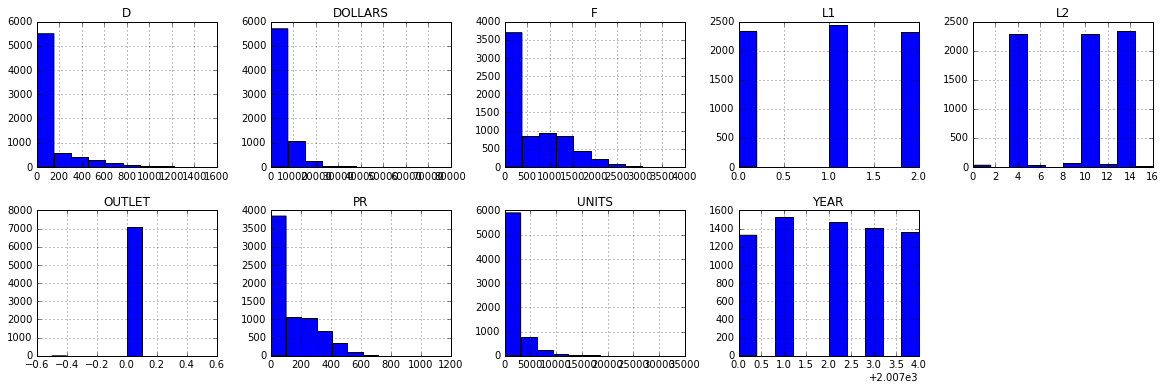

In [185]:
# looking at the histogram and statistics of the features to make sure that most of the features have good variance and enough data#
data_preped_grp.hist(figsize=(20,50), layout=(15,5))
data_preped_grp.describe()

# Outlier Detection and Removal

**We assume that all features have Gaussian distribution and detect outliers based on the following rule:**

Detect a column with extreme outlier if:

$mean(col)-10*\sigma  <value < mean(col)+10*\sigma$

In [186]:
# function to detect the outliers withing each column and omit them
def outlier_detector(data):
    out_col=[]
    data=data.copy()
    for col in data.describe().columns:
        maxx = data.describe()[col]['max']
        minn = data.describe()[col]['min']
        mean = data.describe()[col]['mean']
        std =  data.describe()[col]['std']

        # detecting outliers
        if maxx>(mean+10*std):
            out_col.append(col)
            print "outliers for column", col, "are",np.unique(data[col].ix[data[col]>(mean+10*std)].values)
            # omitting outliers
            data=data[data[col]<(mean+10*std)]
        elif minn<(mean-10*std):
            out_col.append(col)
            print "outliers for column", col, "are",np.unique(saltsnck_preped[col].ix[saltsnck_preped[col]>(mean-10*std)].values)
            # omitting outliers
            data=data[data[col]>(mean-10*std)]
    print "columns containing outliers are: ",out_col
    return data

In [187]:
data_preped_grp=outlier_detector(data_preped_grp)

outliers for column DOLLARS are [ 65323.39  70254.79  71730.87  75962.77]
outliers for column UNITS are [29390 30984]
columns containing outliers are:  ['DOLLARS', 'UNITS']


# Natutral growth analysis

In time series sale forcast we need to take into account the natural growth/decline of each store. So we compared the sales of each store year-over-year compared to 2008 and didn't see much change. So we assumed that there are no natural growth/decline.

In [188]:
print "growth factor for 2011:", data_preped_grp.ix[data_preped_grp['YEAR']==2011][['DOLLARS']].sum()/(data_preped_grp.ix[data_preped_grp['YEAR']==2008][['DOLLARS']].sum())
print "growth factor for 2010:", data_preped_grp.ix[data_preped_grp['YEAR']==2010][['DOLLARS']].sum()/(data_preped_grp.ix[data_preped_grp['YEAR']==2008][['DOLLARS']].sum())
print "growth factor for 2009::", data_preped_grp.ix[data_preped_grp['YEAR']==2009][['DOLLARS']].sum()/(data_preped_grp.ix[data_preped_grp['YEAR']==2008][['DOLLARS']].sum())
print "growth factor for 2008:", 1

growth factor for 2011: DOLLARS    1.070066
dtype: float64
growth factor for 2010: DOLLARS    1.030598
dtype: float64
growth factor for 2009:: DOLLARS    0.978278
dtype: float64
growth factor for 2008: 1


# Modeling 

### Classification and Regression Models
Next we start building our models. For this example we build a yearly model. But as described in function `data_group(data_preped,outlet,method)` the `method` can be changed from yearly to seasonal or monthly to aggregate the data at finer time resolutio. We have 3 different targets:
- L2: The most popular item within each category
- UNITS: The total number of a specific product category item sold
- DOLLARS: The total dollar value sold for a specific product category.

### Evaluation Method:

While we used 10 fold CV for evaluation our models 0,1,2, and 3, for evaluating the performance of our final model, we hold out the 2011 data and used it as a test set while training our model on the data for 2008-2010. Please note that if we use 10 fold CV, we get even higher scores (2%-3%) but we believe for time varying target, using the future data set as test set makes more sense. 

### Decision Tree on L2 (most popular item within a category ): Classification

In [189]:
# building train and test data set by holding out the 2011 data as test data
X_train = data_preped_grp.ix[data_preped_grp['YEAR']!=2011][['PR','D','F','OUTLET','L1']]
y_train = data_preped_grp.ix[data_preped_grp['YEAR']!=2011][['L2']]
X_test = data_preped_grp.ix[data_preped_grp['YEAR']==2011][['PR','D','F','OUTLET','L1']]
y_test = data_preped_grp.ix[data_preped_grp['YEAR']==2011][['L2']]
# using a simple Decision Tree Classifier for classifying L2
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)
print "score on train set:", dtree.score(X_train, y_train)
print "score on test set:", dtree.score(X_test, y_test)

score on train set: 0.992330486317
score on test set: 0.983063328424


### Random Forest Regressor for predicting the sale (DOLLARS) for any product category: Regression

In [4]:
X_train = data_preped_grp.ix[data_preped_grp['YEAR']!=2011][['PR','D','F','OUTLET','L1']]
y_train = data_preped_grp.ix[data_preped_grp['YEAR']!=2011]['DOLLARS']
X_test = data_preped_grp.ix[data_preped_grp['YEAR']==2011][['PR','D','F','OUTLET','L1']]
y_test = data_preped_grp.ix[data_preped_grp['YEAR']==2011]['DOLLARS']
tree = RandomForestRegressor(random_state=0)
tree.fit(X_train, y_train)
print "score on train set:", tree.score(X_train, y_train)
print "score on test set:", tree.score(X_test, y_test)

score on train set: 0.976219795736
score on test set: 0.881157684855


# Visualizing the Accuracy of the Model
In this part we plot the predicted values of the sale (DOLLARS) by the model versus the actual values of sale. The closer the blue dots are to the red line in the below plot, the more accurate the model.

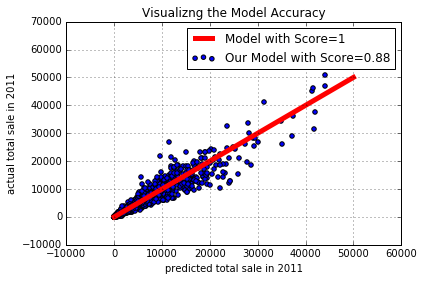

In [53]:
# plotting predicted vs actual DOLLARS
plt.scatter(tree.predict(X_test.head(100000)),y_test.iloc[:100000], label='Our Model with Score=0.88')
plt.plot(range(50000), range(50000), linewidth=5, color='r', label='Model with Score=1')
plt.xlabel('predicted total sale in 2011')
plt.ylabel('actual total sale in 2011')
plt.grid()
plt.title('Visualizng the Model Accuracy')
plt.legend()

### Random Forest Regressor for predicting the number of units sold (UNITS) for any product category: Regression

In [192]:
X_train = data_preped_grp.ix[data_preped_grp['YEAR']!=2011][['PR','D','F','OUTLET','L1']]
y_train = data_preped_grp.ix[data_preped_grp['YEAR']!=2011]['UNITS']
X_test = data_preped_grp.ix[data_preped_grp['YEAR']==2011][['PR','D','F','OUTLET','L1']]
y_test = data_preped_grp.ix[data_preped_grp['YEAR']==2011]['UNITS']
tree = RandomForestRegressor(random_state=0)
tree.fit(X_train, y_train)
print "score on train set:", tree.score(X_train, y_train)
print "score on test set:", tree.score(X_test, y_test)

score on train set: 0.974298175253
score on test set: 0.861411745343


### Using GridSearchCV for tuning the Random Forest Regressor parameters

In [234]:
X_train = data_preped_grp.ix[data_preped_grp['YEAR']!=2011][['PR','D','F','OUTLET','L1']]
y_train = data_preped_grp.ix[data_preped_grp['YEAR']!=2011]['DOLLARS']
X_test = data_preped_grp.ix[data_preped_grp['YEAR']==2011][['PR','D','F','OUTLET','L1']]
y_test = data_preped_grp.ix[data_preped_grp['YEAR']==2011]['DOLLARS']
parameters = {'n_estimators':range(10,101,10),'max_depth':range(1,10,5),\
              'min_samples_split':range(2,10,5),'min_samples_leaf':range(1,10,5)}
tree = RandomForestRegressor(warm_start=True)
clf = grid_search.GridSearchCV(tree, parameters, cv=10)
clf.fit(X_train, y_train)
print "The best set of parameters are: ", clf.best_params_
print "The best score is: ", clf.best_score_

The best set of parameters are:  {'min_samples_split': 2, 'n_estimators': 40, 'max_depth': 6, 'min_samples_leaf': 1}
The best score is:  0.870872358433


# More Complex Models :Stacking
In this section we tried a 2-level stacking with 3 base classifiers/regressors and 1 meta classifier/regressor to see if it can improve the accuracy of our models. We tried all combinations of several classifiers/regressors and picked the one with the best score.

We realized that stacking didn't help to increase the performance of our models whenever the accuracy of our model was already high (for example score of 0.88 for yearly model). However, for monthly model where the performance of our model was slightly lower (score of 0.7) it boosted the score of our model by 2%-5%.

In [54]:
## writing a class with fit/predict/scoring method, to fit the sub-classifiers onto the data and fit
# a meta classifier on top of the base classifier and evaluate the performance
class stacked_classifier():
    def __init__(self, base_classifiers=None, meta_classifier=None):
        self.base_classifiers = base_classifiers
        self.meta_classifier = meta_classifier


    def fit(self, X, y):
        for classifier in self.base_classifiers:
            classifier.fit(X, y)
        X_meta=self.predict_base(X)
        self.meta_classifier.fit(X_meta, y)

    def predict_base(self, X):
        self.predictions = np.zeros(len(X))
        for classifier in self.base_classifiers:
            self.predictions=np.column_stack([self.predictions, classifier.predict(X)])
        return self.predictions
        
    def scoring(self,X,y):
        clf_score=[]
        for classifier in self.base_classifiers:
            clf_score.append(classifier.score(X, y))
        clf_score.append(self.meta_classifier.score(self.predict_base(X),y))
        return clf_score

### Creating sub and meta classifiers/Regressors

In [203]:
#Creating sub and meta classifiers
DTC = DecisionTreeClassifier(random_state=0)
LR = linear_model.LogisticRegression()
RC =  linear_model.RidgeClassifier(random_state=0)
ETC = ExtraTreeClassifier(random_state=32)
KNC = KNeighborsClassifier ()
BC = BaggingClassifier()

In [225]:
#Creating sub and meta regressors
DTR = DecisionTreeRegressor(random_state=0)
RR =  linear_model.Ridge(random_state=0)
BRR= linear_model.BayesianRidge()
ETR = ExtraTreeRegressor(random_state=0)
LR = linear_model.Lasso()
RFR = RandomForestRegressor(random_state=0)

### Importing the results of all possible combinations of base+meta classifier into a DataFrame

In [55]:
# Function to import the results of all possible combinations of base+meta classifier into a DataFrame
def stack_scoring(clf_dict, score_df, n, X_train, X_test, y_train, y_test):
    l=0
    for clf in combinations(clf_dict,n):
        stacked_clf=stacked_classifier(base_classifiers=clf[0:n-1], meta_classifier=clf[n-1])
        stacked_clf.fit(X_train,y_train)
        clf_scores=[clf_dict.get(clf[i]) for i in range(n)]+stacked_clf.scoring(X_test,y_test)
        score_df.loc[l]= clf_scores
        l+=1
    return score_df

## Stacking for Predicting L2

In [206]:
X_train = data_preped_grp.ix[data_preped_grp['YEAR']!=2011][['PR','D','F','OUTLET','L1']]
y_train = data_preped_grp.ix[data_preped_grp['YEAR']!=2011]['L2']
X_test = data_preped_grp.ix[data_preped_grp['YEAR']==2011][['PR','D','F','OUTLET','L1']]
y_test = data_preped_grp.ix[data_preped_grp['YEAR']==2011]['L2']
clf_dict={DTC: 'Decision Tree',LR:'Logistic Regression',RC: 'Ridge', ETC: 'Extra Tree', KNC:'KNeighbor', BC:'Bagging'}
score_df = pd.DataFrame(columns=['Base1','Base2','Base3', 'Meta','Base1 Score','Base2 Score','Base3 Score', 'Meta Score'])

stack_2_base_score = stack_scoring(clf_dict,score_df, 4, X_train, X_test, y_train, y_test)
print "Best stacked classifier with 2 sub-classifier is: \n", stack_2_base_score.loc[stack_2_base_score['Meta Score'].idxmax()]
stack_2_base_score

Best stacked classifier with 2 sub-classifier is: 
Base1          Logistic Regression
Base2                Decision Tree
Base3                        Ridge
Meta                     KNeighbor
Base1 Score               0.877911
Base2 Score               0.983063
Base3 Score               0.947717
Meta Score                0.984536
Name: 1, dtype: object


,Base1,Base2,Base3,Meta,Base1 Score,Base2 Score,Base3 Score,Meta Score
0,Logistic Regression,Decision Tree,Ridge,Extra Tree,0.877911,0.983063,0.947717,0.983063
1,Logistic Regression,Decision Tree,Ridge,KNeighbor,0.877911,0.983063,0.947717,0.984536
2,Logistic Regression,Decision Tree,Ridge,Bagging,0.877911,0.983063,0.947717,0.980854
3,Logistic Regression,Decision Tree,Extra Tree,KNeighbor,0.877911,0.983063,0.983800,0.983063
4,Logistic Regression,Decision Tree,Extra Tree,Bagging,0.877911,0.983063,0.983800,0.981591
5,Logistic Regression,Decision Tree,KNeighbor,Bagging,0.877911,0.983063,0.913108,0.979381
6,Logistic Regression,Ridge,Extra Tree,KNeighbor,0.877911,0.947717,0.983800,0.984536
7,Logistic Regression,Ridge,Extra Tree,Bagging,0.877911,0.947717,0.983800,0.981591
8,Logistic Regression,Ridge,KNeighbor,Bagging,0.877911,0.947717,0.913108,0.982327
9,Logistic Regression,Extra Tree,KNeighbor,Bagging,0.877911,0.983800,0.913108,0.980854


## Stacking for forecasting the sales (DOLLARS)

In [228]:
X_train = data_preped_grp.ix[data_preped_grp['YEAR']!=2011][['PR','D','F','OUTLET','L1']]
y_train = data_preped_grp.ix[data_preped_grp['YEAR']!=2011]['DOLLARS']
X_test = data_preped_grp.ix[data_preped_grp['YEAR']==2011][['PR','D','F','OUTLET','L1']]
y_test = data_preped_grp.ix[data_preped_grp['YEAR']==2011]['DOLLARS']
clf_dict={DTR: 'Decision Tree',RR: 'Ridge', ETR: 'Extra Tree', BRR:'Bayesian Ridge', LR:'Lasso', RFR: 'Random Forrest'}
score_df = pd.DataFrame(columns=['Base1','Base2','Base3', 'Meta','Base1 Score','Base2 Score','Base3 Score', 'Meta Score'])

stack_2_base_score = stack_scoring(clf_dict,score_df, 4, X_train, X_test, y_train, y_test)
print "Best stacked classifier with 2 sub-classifier is: \n", stack_2_base_score.loc[stack_2_base_score['Meta Score'].idxmax()]
stack_2_base_score

Best stacked classifier with 2 sub-classifier is: 
Base1                   Lasso
Base2          Bayesian Ridge
Base3          Random Forrest
Meta               Extra Tree
Base1 Score          0.692909
Base2 Score          0.692657
Base3 Score          0.880851
Meta Score           0.863544
Name: 14, dtype: object


,Base1,Base2,Base3,Meta,Base1 Score,Base2 Score,Base3 Score,Meta Score
0,Decision Tree,Ridge,Lasso,Bayesian Ridge,0.750570,0.692926,0.692909,0.750570
1,Decision Tree,Ridge,Lasso,Random Forrest,0.750570,0.692926,0.692909,0.751602
2,Decision Tree,Ridge,Lasso,Extra Tree,0.750570,0.692926,0.692909,0.750624
3,Decision Tree,Ridge,Bayesian Ridge,Random Forrest,0.750570,0.692926,0.692657,0.751053
4,Decision Tree,Ridge,Bayesian Ridge,Extra Tree,0.750570,0.692926,0.692657,0.752212
5,Decision Tree,Ridge,Random Forrest,Extra Tree,0.750570,0.692926,0.880851,0.783937
6,Decision Tree,Lasso,Bayesian Ridge,Random Forrest,0.750570,0.692909,0.692657,0.751056
7,Decision Tree,Lasso,Bayesian Ridge,Extra Tree,0.750570,0.692909,0.692657,0.752212
8,Decision Tree,Lasso,Random Forrest,Extra Tree,0.750570,0.692909,0.880851,0.785596
9,Decision Tree,Bayesian Ridge,Random Forrest,Extra Tree,0.750570,0.692657,0.880851,0.774660


# Prescriptive Analysis (Future Work)
In this section we tried to approach the problem from a prescriptive analysis point of view. i.e., to build a model for each specific value of each feature (several models based on the number of unique values of each features) and quantify the impact of each feature on the sales. We didn't have time to finish this part but as it can be visually verified from the table below, all features have strong impact on the outcome of the sales. So, prescriptive analysis can work really well on this data set.

In [65]:
sample=X_test.head(10)
sample.ix[:,'predicted sale']=tree.predict(X_test.head(10))
sample.ix[:,'actual sale']=y_test.iloc[:10]
sample=sample.rename(columns={'PR':'Total Number of Promotions', 'D':'Average Display Size','F':'Ad Importance','L1':'Product Category'})
sample

,Total Number of Promotions,Average Display Size,Ad Importance,OUTLET,Product Category,predicted sale,actual sale
9,224,5,1122,0,0,10102.708,9244.18
10,380,200,1838,0,1,7160.160,8208.54
11,60,0,211,0,2,1175.044,983.82
24,322,109,1196,0,0,12564.724,14778.83
25,172,249,1174,0,1,4805.750,5824.10
26,26,0,136,0,2,970.156,1074.03
39,35,37,331,0,0,2569.789,3083.77
40,167,443,1810,0,1,12472.628,15847.39
41,5,0,71,0,2,531.743,564.05
54,322,18,1321,0,0,10671.119,12077.77
